# Hierarchical model fit on Splatter datasets

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Loading model  ppca
Model loaded succesfully from cache.
Loading model  gmm
Model loaded succesfully from cache.
Loading model  moppcas
Model loaded succesfully from cache.
Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Loading model  gmm_weighted
Model loaded succesfully from cache.


## Comparison NUTS and VB in terms of speed and accuracy

### Dataset 1

In [136]:
timings_nuts = []
timings_vb = []
knots_nuts_try = []
knots_vb_try = []
knots_nuts_found = []
knots_vb_found = []
acc_scores_nuts = []
acc_scores_vb = []

for num_dims in [5,25, 50,150, 250]:
    print('Analyzing dataset of %i genes: '%num_dims)
    with open('./splattersets/splatter_small_%i.csv'%num_dims) as file:
        text = csv.reader(file)
        data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
    with open('./splattersets/splatter_small_%i_labels.csv'%num_dims) as file:
        text = csv.reader(file)
        labels_raw = np.array(list(text))
    data = np.log(data+1)
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]
    labelnames = ['gene '+str(i+1) for i in set(labels)]
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_vb, knots_vb_trd, knots_vb_fnd = model.fit(data, max_depth=5, k_max=3, samplingmethod='VB', plotting=False)
    timings_vb.append(times_vb)
    knots_vb_try.append(knots_vb_trd)
    knots_vb_found.append(knots_vb_fnd)
    scores_vb = model.visual_score(labels, plotlegend=True, savefigs=True, labelnames = labelnames, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_vb.append(scores_vb)
    
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_nuts, knots_nuts_trd, knots_nuts_fnd = model.fit(data, max_depth=5, k_max=3, samplingmethod='NUTS', plotting=False)
    timings_nuts.append(times_nuts)
    knots_nuts_try.append(knots_nuts_trd)
    knots_nuts_found.append(knots_nuts_fnd)
    scores_nuts = model.visual_score(labels, plotlegend=True, savefigs=True, labelnames = labelnames, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_nuts.append(scores_nuts)
    
#     plt.plot(range(1,len(times_vb)+1), times_vb, label='VB')
#     plt.plot(range(1,len(times_nuts)+1), times_nuts, label='NUTS')
#     plt.title('Seconds per (Mo-)PPCAs')
#     plt.ylabel('seconds')
#     plt.legend()
#     plt.show()
    
#     plt.plot(range(len(scores_vb)), scores_vb, label='VB')
#     plt.xlabel('level')
#     plt.ylabel('w. accuracy')
#     plt.plot(range(len(scores_nuts)), scores_nuts, label='NUTS')
#     plt.legend()
#     plt.plot()
    

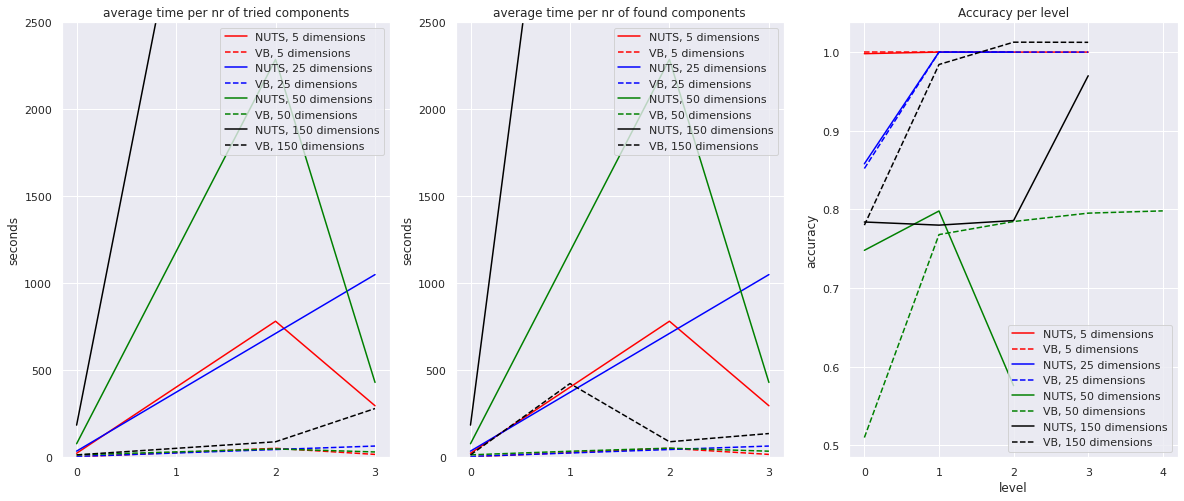

In [137]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(131)
ax.set_title('average time per nr of tried components')
for i in range(4):
    boxpoints_nuts = []
    nanindex_nuts = []
    boxpoints_vb = []
    nanindex_vb = []
    for j in [0,1,2,3]:
        if len(np.array(timings_nuts[i])[np.array(knots_nuts_try[i])==j])>0:
            boxpoints_nuts.append(np.mean(np.array(timings_nuts[i])[np.array(knots_nuts_try[i])==j]))
            nanindex_nuts.append(True)
        else:
            boxpoints_nuts.append(0)
            nanindex_nuts.append(False)
        if len(np.array(timings_vb[i])[np.array(knots_vb_try[i])==j])>0:
            boxpoints_vb.append(np.mean(np.array(timings_vb[i])[np.array(knots_vb_try[i])==j]))
            nanindex_vb.append(True)
        else:
            boxpoints_vb.append(0)
            nanindex_vb.append(False)
    nanindex_nuts = np.array(nanindex_nuts)
    boxpoints_nuts = np.array(boxpoints_nuts)
    nanindex_vb = np.array(nanindex_vb)
    boxpoints_vb = np.array(boxpoints_vb)
    ax.plot(np.array([0,1,2,3])[nanindex_nuts],boxpoints_nuts[nanindex_nuts], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(np.array([0,1,2,3])[nanindex_vb],boxpoints_vb[nanindex_vb], label='VB, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i], linestyle='--')
i+=1
# ax.plot(knots_vb_found[i], timings_vb[i], label='V, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple', 'purple'][i])
ax.legend(loc='upper right')
ax.set_ylabel('seconds')
ax.set_ylim((0,2500))
ax.set_xticks([0,1,2,3])
# ax.set_xticklabels(['PPCA', 'MoPPCAs', 'MoPPCAs', 'MoPPCAs', 'MoPPCAs'])
ax = fig.add_subplot(132)
ax.set_title('average time per nr of found components')
for i in range(4):
    boxpoints_nuts = []
    nanindex_nuts = []
    boxpoints_vb = []
    nanindex_vb = []
    for j in [0,1,2,3]:
        if len(np.array(timings_nuts[i])[np.array(knots_nuts_found[i])==j])>0:
            boxpoints_nuts.append(np.mean(np.array(timings_nuts[i])[np.array(knots_nuts_found[i])==j]))
            nanindex_nuts.append(True)
        else:
            boxpoints_nuts.append(0)
            nanindex_nuts.append(False)
        if len(np.array(timings_vb[i])[np.array(knots_vb_found[i])==j])>0:
            boxpoints_vb.append(np.mean(np.array(timings_vb[i])[np.array(knots_vb_found[i])==j]))
            nanindex_vb.append(True)
        else:
            boxpoints_vb.append(0)
            nanindex_vb.append(False)
    nanindex_nuts = np.array(nanindex_nuts)
    boxpoints_nuts = np.array(boxpoints_nuts)
    nanindex_vb = np.array(nanindex_vb)
    boxpoints_vb = np.array(boxpoints_vb)
    ax.plot(np.array([0,1,2,3])[nanindex_nuts],boxpoints_nuts[nanindex_nuts], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(np.array([0,1,2,3])[nanindex_vb],boxpoints_vb[nanindex_vb], label='VB, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i], linestyle='--')
i+=1
ax.legend(loc='upper right')
ax.set_ylabel('seconds')
ax.set_ylim((0,2500))
ax.set_xticks([0,1,2,3])
ax = fig.add_subplot(133)
ax.set_title('Accuracy per level')
for i in range(4):
    ax.plot(range(len(acc_scores_nuts[i])), acc_scores_nuts[i], label='NUTS, %i dimensions'%[5,25, 50,150, 250][i], c= ['red', 'blue', 'green', 'black', 'purple'][i])
    ax.plot(range(len(acc_scores_vb[i])), acc_scores_vb[i], label='VB, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple'][i])
i+=1
# ax.plot(range(len(acc_scores_vb[i])), acc_scores_vb[i], label='V, %i dimensions'%[5,25, 50,150, 250][i], linestyle='--', c= ['red', 'blue', 'green', 'black', 'purple'][i])
ax.legend(loc='lower right')
ax.set_ylabel('accuracy')
ax.set_xlabel('level')
ax.set_xticks([0,1,2,3,4])
plt.show()

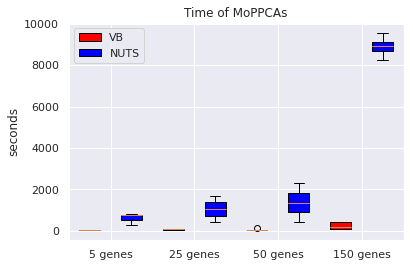

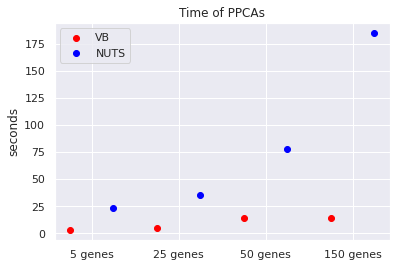

In [174]:
boxpoints = []
names = []
for i in range(4):
    boxpoints.append(timings_vb[i][1:])
    boxpoints.append(timings_nuts[i][1:])
    names.append('%i genes'%[5,25,50,150][i])
box = plt.boxplot(boxpoints, patch_artist=True)
i=0
for patch in box['boxes']:
    patch.set_facecolor(['red','blue'][i%2])
    i+=1
plt.legend(box['boxes'][:2],['VB','NUTS'])
plt.title('Time of MoPPCAs')
plt.ylabel('seconds')
plt.xticks(np.arange(1.5,len(boxpoints)+1.5,2),names)
plt.show()

boxpoints_vb = []
boxpoints_nuts = []
names = []
for i in range(4):
    boxpoints_vb.append(timings_vb[i][0])
    boxpoints_nuts.append(timings_nuts[i][0])
    names.append('%i genes'%[5,25,50,150][i])
# box = plt.boxplot(boxpoints, patch_artist=True)
plt.scatter(range(1,8,2),boxpoints_vb, c='red', label='VB')
plt.scatter(range(2,9,2),boxpoints_nuts, c='blue', label='NUTS')
plt.legend()
plt.title('Time of PPCAs')
plt.ylabel('seconds')
plt.xticks(np.arange(1.5,len(boxpoints)+1.5,2),names)
plt.show()

### Dataset 2

In [ ]:
timings_nuts2 = []
timings_vb2 = []
acc_scores_nuts2 = []
acc_scores_vb2 = []

for num_dims in [5,25, 50,150, 250, 500]:
    with open('./splattersets/splatter_big_%i.csv'%num_dims) as file:
        text = csv.reader(file)
        data2 = np.array(np.array(list(text))[1:,1:].T, dtype=int)
    with open('./splattersets/splatter_big_%i_labels.csv'%num_dims) as file:
        text = csv.reader(file)
        labels_raw2 = np.array(list(text))
    labels2 = np.unique(labels_raw[1:,1], return_inverse=True)[1]
    labelnames2 = ['gene '+str(i+1) for i in set(labels2)]
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_vb = model.fit(data2, max_depth=5, k_max=3, samplingmethod='VB', plotting=False)
    timings_vb2.append(times_vb)
    scores_vb = model.visual_score(labels2, plotlegend=True, savefigs=True, labelnames = labelnames2, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_vb2.append(scores_vb)
    
    model = hierarchical_model()
    latent, cats_per_lvl, probs, times_nuts = model.fit(data2, max_depth=5, k_max=3, samplingmethod='NUTS', plotting=False)
    timings_nuts2.append(times_nuts)
    scores_nuts = model.visual_score(labels2, plotlegend=True, savefigs=True, labelnames = labelnames2, plot_hmppca = False, plot_hmppca_logres = False, plot_real = True, plot_logreg = True)
    acc_scores_nuts2.append(scores_nuts)
#     plt.plot(range(1,len(times_vb)+1), times_vb, label='VB')
#     plt.plot(range(1,len(times_nuts)+1), times_nuts, label='NUTS')
#     plt.title('Seconds per (Mo-)PPCAs')
#     plt.ylabel('seconds')
#     plt.legend()
#     plt.show()
    
#     plt.plot(range(len(scores_vb)), scores_vb, label='VB')
#     plt.xlabel('level')
#     plt.ylabel('w. accuracy')
#     plt.plot(range(len(scores_nuts)), scores_nuts, label='NUTS')
#     plt.legend()
#     plt.plot()
    

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
for i in range(4):
    ax.plot(range(len(timings_nuts2[i])), timings_nuts2[i], label='NUTS, %i dimensions'%[5,10,25,100][i], c= ['red', 'blue', 'green', 'black'][i])
    ax.plot(range(len(timings_vb2[i])), timings_vb2[i], label='V, %i dimensions'%[5,10,25,100][i], linestyle='--', c= ['red', 'blue', 'green', 'black'][i])
    ax.legend()
    ax.set_ylabel('seconds')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['PPCA', 'MoPPCAs', 'MoPPCAs', 'MoPPCAs', 'MoPPCAs'])
ax = fig.add_subplot(122)
for i in range(4):
    ax.plot(range(len(acc_scores_nuts2[i])), acc_scores_nuts2[i], label='NUTS, %i dimensions'%[5,10,25,100][i], c= ['red', 'blue', 'green', 'black'][i])
    ax.plot(range(len(acc_scores_vb2[i])), acc_scores_vb2[i], label='VB, %i dimensions'%[5,10,25,100][i], linestyle='--', c= ['red', 'blue', 'green', 'black'][i])
    ax.legend()
    ax.set_ylabel('accuracy')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['PPCA', 'MoPPCAs', 'MoPPCAs', 'MoPPCAs', 'MoPPCAs'])
plt.show()

In [ ]:
labelnames = ['gene '+str(i+1) for i in set(labels)]

In [ ]:
model.visual_score(labels, plotlegend=True, savefigs=True, labelnames = labelnames)